# Visualizing Probe Layer Weights

This notebook was used to experiment with visualizing the different layer weights, particularly for models that performed well with zero hidden layers, since we hoped this would help us derive insight into the Jukebox outputs.

In [5]:
import numpy as np
import IPython.display as ipd
import json
import glob
import time
import copy
import pickle

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch

import matplotlib.pyplot as plt
from tqdm import tqdm 

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [9]:
class BaseModel(nn.Module):
    def __init__(self, hidden_sizes=[512], p=.5):
        super(BaseModel, self).__init__()
        input_size = 4800
        self.hidden_sizes = [input_size] + hidden_sizes + [1]
        for i in range(1, len(self.hidden_sizes)):
            setattr(self, f"hidden_{i}", nn.Linear(self.hidden_sizes[i-1], self.hidden_sizes[i]))
        self.dropout = nn.Dropout(p=p)
        
    def forward(self, x):
        x = self.dropout(x)
        for i in range(1, len(self.hidden_sizes)-1):
            x = getattr(self, f"hidden_{i}")(x)
            x = F.relu(x)
            x = self.dropout(x)
        x = getattr(self, f"hidden_{len(self.hidden_sizes)-1}")(x) # output
        return x

In [149]:
class IRdataset(Dataset):
    def __init__(self, instrument='voice', method='concat'):
        
        # not every sample is annotated for every instrument.
        # e.g. for a specific sample nobody might've checked whether or not 
        # there was voice. When constructing our dataset, we only
        # take samples for which the instrument's presence was annotated.
        if method == 'concat':
            fname_func = fname_to_path_concat
            feature_path = "features2/*.npy"
        elif method == 'upsample':
            fname_func = fname_to_path_upsample
            feature_path = "features/*.npy"

        self.mask = Y_mask[:, class_map[instrument]]
        self.fnames = np.array([fname_func(fname) for fname in sample_key])
        existing_files = glob.glob(feature_path)
        fname_exists_mask = np.array([x in existing_files for x in self.fnames])
        self.mask = self.mask * fname_exists_mask
        
        # 
        self.probabilities = Y_true[self.mask][:,class_map[instrument]].astype('float32')
        self.input_files = [np.load(x).astype('float32') for x in self.fnames[self.mask]]
        
    def __len__(self):
        return self.probabilities.shape[0]
        # return 100 # for debug
    
    def __getitem__(self, idx):
        return self.input_files[idx], self.probabilities[idx]
    
    def get_audio(self, idx):
        fname = sample_key[self.mask][idx]
        path = '../openmic-2018/audio/' + fname[0:3] + '/' + fname + '.ogg'
        print(path)
        return ipd.Audio(path)

In [150]:
with open("gs_output_concatenated.pkl", 'rb') as handle: # load concatenated gridsearch output
    models, losses, val_accs, params = pickle.load(handle)

In [441]:
def visualize_output_layer(models, instrument):
    """
    Plot weight value vs weight index for the output layer of the model, given a dictionary of
    models and a desired instrument to examine. 
    """
    model = models[instrument]
    out_layer = list(model.parameters())[-2].data
    out_layer = out_layer.cpu().detach().numpy()[0]
    fig, ax = plt.subplots(1,1,figsize = (10,5))
    plt.stem(out_layer)
    plt.title('Final Activation Weights for ' + instrument)
    plt.ylabel('Weight Magnitude')
    plt.xlabel('Layer Parameters')

## Visualize output layer

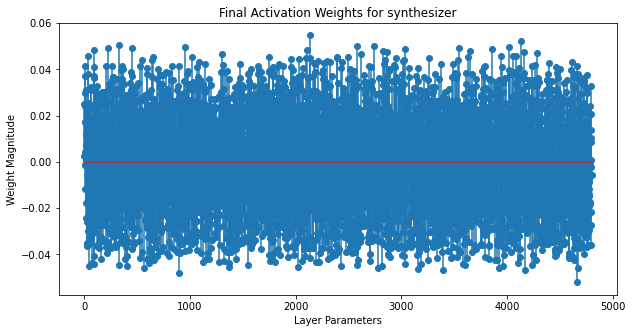

In [153]:
visualize_output_layer(models, 'synthesizer')

## Evaluate f1/plot histogram of predictions

In [154]:
fname_to_path_concat  = lambda fname: f"features2/{fname}.npy"
# fname_to_path_upsample = lambda fname: f"features/{fname}.npy"

def load_dl_dict(instrument='voice', method='concat'):
    """
    Load the dataloader dictionary that was used to perform the gridsearch.
    Note that the dataloders use weighted sampling with replacement to account for unbalanced
    classes, so this is not to be used for evaluating test metrics!
    """
    with open("test_sets/" + method + "/" + instrument + ".pkl", "rb") as handle:
        dl_dict = pickle.load(handle)
    return dl_dict

def get_test_dataloader(instrument='voice', method='concat'):
    """
    Load the test dataloader, craeting a new 
    """
    with open("test_sets/" + method + "/" + instrument + ".pkl", "rb") as handle:
        dl_dict = pickle.load(handle)
    test_dl = dl_dict['test']
    return test_dl

In [440]:
def get_f1(instrument, model, dl = None):
    """
    Given an instrument (as a string), a model, and a dataloader, compute the F1 score of the model.
    Display a histogram of predictions on the test set.
    """
    model.eval()   # Set model to evaluate mode
    true_pos = 0
    false_pos = 0
    false_neg = 0
    count = 0
    count2=0
    count3 = 0
    temp = np.array([]) # ho
    for step, (x, y) in enumerate(dl):
        x = x.to(device)
        outputs = model(x).flatten()
        outs = torch.sigmoid(outputs).cpu().detach().numpy()
        temp = np.concatenate((temp, outs))
        preds = np.where(outs>.5, 1, 0).astype('int')
        true  = np.round(y.numpy().astype('int'))
        true_pos  += np.sum( preds[true==preds]*1.0)
        false_pos += np.sum((preds[true!=preds] == 1)*1.0)
        false_neg += np.sum((preds[true!=preds] == 0)*1.0)
        count3 +=sum(true)
    p = true_pos / (true_pos + false_pos)
    r = true_pos / (true_pos + false_neg)
    f1 = 2*(p * r)/(p + r)
    plt.hist(temp, bins = 50)
    plt.title("Test Set Predictions for " + instrument)
    plt.ylabel("Number of Predictions")
    plt.xlabel("Confidence that " + instrument + " is present")
    plt.figure()
    return f1

0.9242957746478874
0.9776536312849162
0.559375


0.9502262443438915

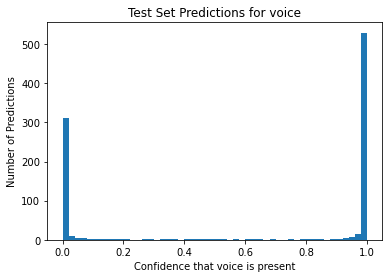

<Figure size 432x288 with 0 Axes>

In [439]:
instrument = 'voice'
dl_dict = load_dl_dict(instrument)
model = models[instrument]
dl=dl_dict['train']
dl = DataLoader(dl.dataset, batch_size=32)
get_f1(instrument, model, dl)

tensor(0.3436)


0.43686006825938567

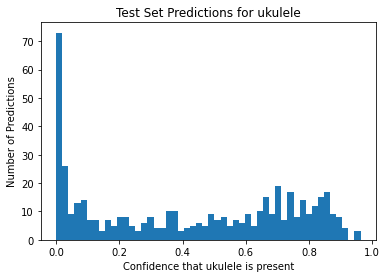